<a href="https://colab.research.google.com/github/arshad831/GenerativeAI/blob/main/Copy_of_LangChain_E_Commerce_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain E-Commerce Chatbot

**GitHub repo:** https://github.com/MoRaouf/LangChain-Ecommerce-Chatbot

**Dataset link:** https://www.kaggle.com/datasets/thedevastator/the-home-depot-products-dataset

## Install & load libraries

In [ ]:
!pip install langchain qdrant_client openai tiktoken

In [ ]:
import os
import json
import pandas as pd

# Qdrant
import qdrant_client
from qdrant_client.http import models
from langchain.vectorstores import Qdrant

# Text Splitter
# from langchain.text_splitter import CharacterTextSplitter

# LLM
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI

# Prompt
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

# Embeddings
from langchain.embeddings.openai import OpenAIEmbeddings

# Chain
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain.chains.question_answering import load_qa_chain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

# Output Parser
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
# from typing import List, Dict

from getpass import getpass
# from uuid import uuid4

#### API Keys

In [ ]:
# API Keys
os.environ['QDRANT_URL'] = 'https://77fd7f57-43ed-4636-ba19-c70f60736415.us-east-1-0.aws.cloud.qdrant.io:6333'
os.environ['QDRANT_API_KEY'] = 'KczoFuZYZdnU6y_-cs7YWKQQwHNc3GHl3ucrp5W9heGbbrivtppTnA'
os.environ['OPENAI_API_KEY'] = getpass('Enter the secret value: ')

Enter the secret value: ··········


In [ ]:
# LangSmith Configuration
# unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"E-commerce Chatbot - Colab"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass('Enter the secret value: ')

Enter the secret value: ··········


## RAG - Retrieval Augmented *Generation*

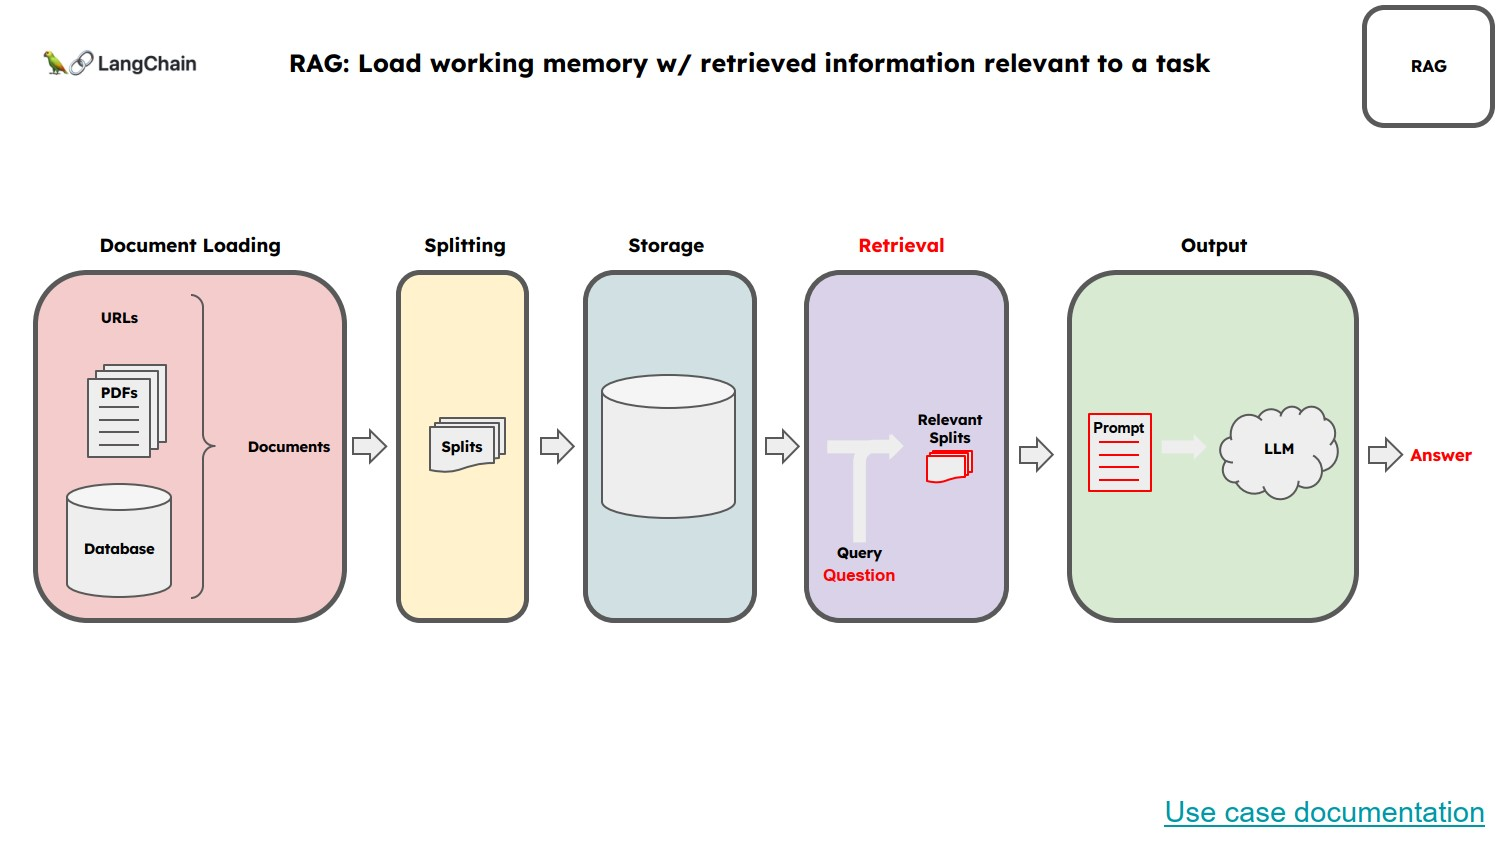

## 1. Dataset Loading

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/MoRaouf/LangChain-Ecommerce-Chatbot/main/home_depot_data.csv'
df = pd.read_csv(dataset_url, index_col=0)
df.head()

In [ ]:
len(df)

2551

In [ ]:
df.isnull().any()

url             False
title           False
images          False
description     False
product_id      False
sku              True
gtin13           True
brand           False
price           False
currency        False
availability    False
uniq_id         False
scraped_at      False
dtype: bool

## 2. Data Processing

Text Splitter Playground: https://langchain-text-splitter.streamlit.app/

```
def get_chunks(text):
    text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = text_splitter.split_text(text)
    return chunks

texts = get_chunks(raw_text)
```

In [ ]:
cols_to_keep = ['url', 'title', 'description', 'brand', 'price', 'currency', 'availability']
df_2 = df[cols_to_keep]
df_2.head(2)

,url,title,description,brand,price,currency,availability
index,,,,,,,
0,https://www.homedepot.com/p/Carhartt-Men-s-3X-...,Men's 3X Large Carbon Heather Cotton/Polyester...,"This heavyweight, water-repellent hooded sweat...",Carhartt,64.99,USD,InStock
1,https://www.homedepot.com/p/Turmode-30-ft-RP-T...,Turmode 30 ft. RP TNC Female to RP TNC Male Ad...,If you need more length between your existing ...,Unbranded,71.61,USD,InStock


In [ ]:
metadata = df_2.to_dict(orient='index')

In [ ]:
metadata

In [ ]:
metadata[0]

{'url': 'https://www.homedepot.com/p/Carhartt-Men-s-3X-Large-Carbon-Heather-Cotton-Polyester-Rain-Defender-Paxton-Heavyweight-Hooded-Zip-Front-Sweatshirt-100614-026/310090686',
 'title': "Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt",
 'description': 'This heavyweight, water-repellent hooded sweatshirt has a zip front for fast layering. ORIGINAL FIT. 13 oz., 75% cotton/25% polyester blend with Rain Defender durable water repellent. Attached, jersey-lined three-piece hood with drawcord closure. Antique-finish brass front zipper. Two front hand-warmer pockets have a hidden security pocket inside. Stretchable, spandex-reinforced rib-knit cuffs and waistband. Locker loop facilitates hanging.',
 'brand': 'Carhartt',
 'price': 64.99,
 'currency': 'USD',
 'availability': 'InStock'}

In [ ]:
# Text data that will be embedded and converted to vectors
texts = [v['title'] for k, v in metadata.items()]
texts[0]

"Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt"

In [ ]:
# Product metadata that we'll store along our vectors
payloads = list(metadata.values())
payloads[0]

{'url': 'https://www.homedepot.com/p/Carhartt-Men-s-3X-Large-Carbon-Heather-Cotton-Polyester-Rain-Defender-Paxton-Heavyweight-Hooded-Zip-Front-Sweatshirt-100614-026/310090686',
 'title': "Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt",
 'description': 'This heavyweight, water-repellent hooded sweatshirt has a zip front for fast layering. ORIGINAL FIT. 13 oz., 75% cotton/25% polyester blend with Rain Defender durable water repellent. Attached, jersey-lined three-piece hood with drawcord closure. Antique-finish brass front zipper. Two front hand-warmer pockets have a hidden security pocket inside. Stretchable, spandex-reinforced rib-knit cuffs and waistband. Locker loop facilitates hanging.',
 'brand': 'Carhartt',
 'price': 64.99,
 'currency': 'USD',
 'availability': 'InStock'}

## 3. Storage - "Qdrant" Vector Store for Similarity Search

Qdrant is a vector similarity search engine. It provides a production-ready service with a convenient API to store, search, and manage points - vectors with an additional payload.

https://python.langchain.com/docs/integrations/vectorstores/qdrant

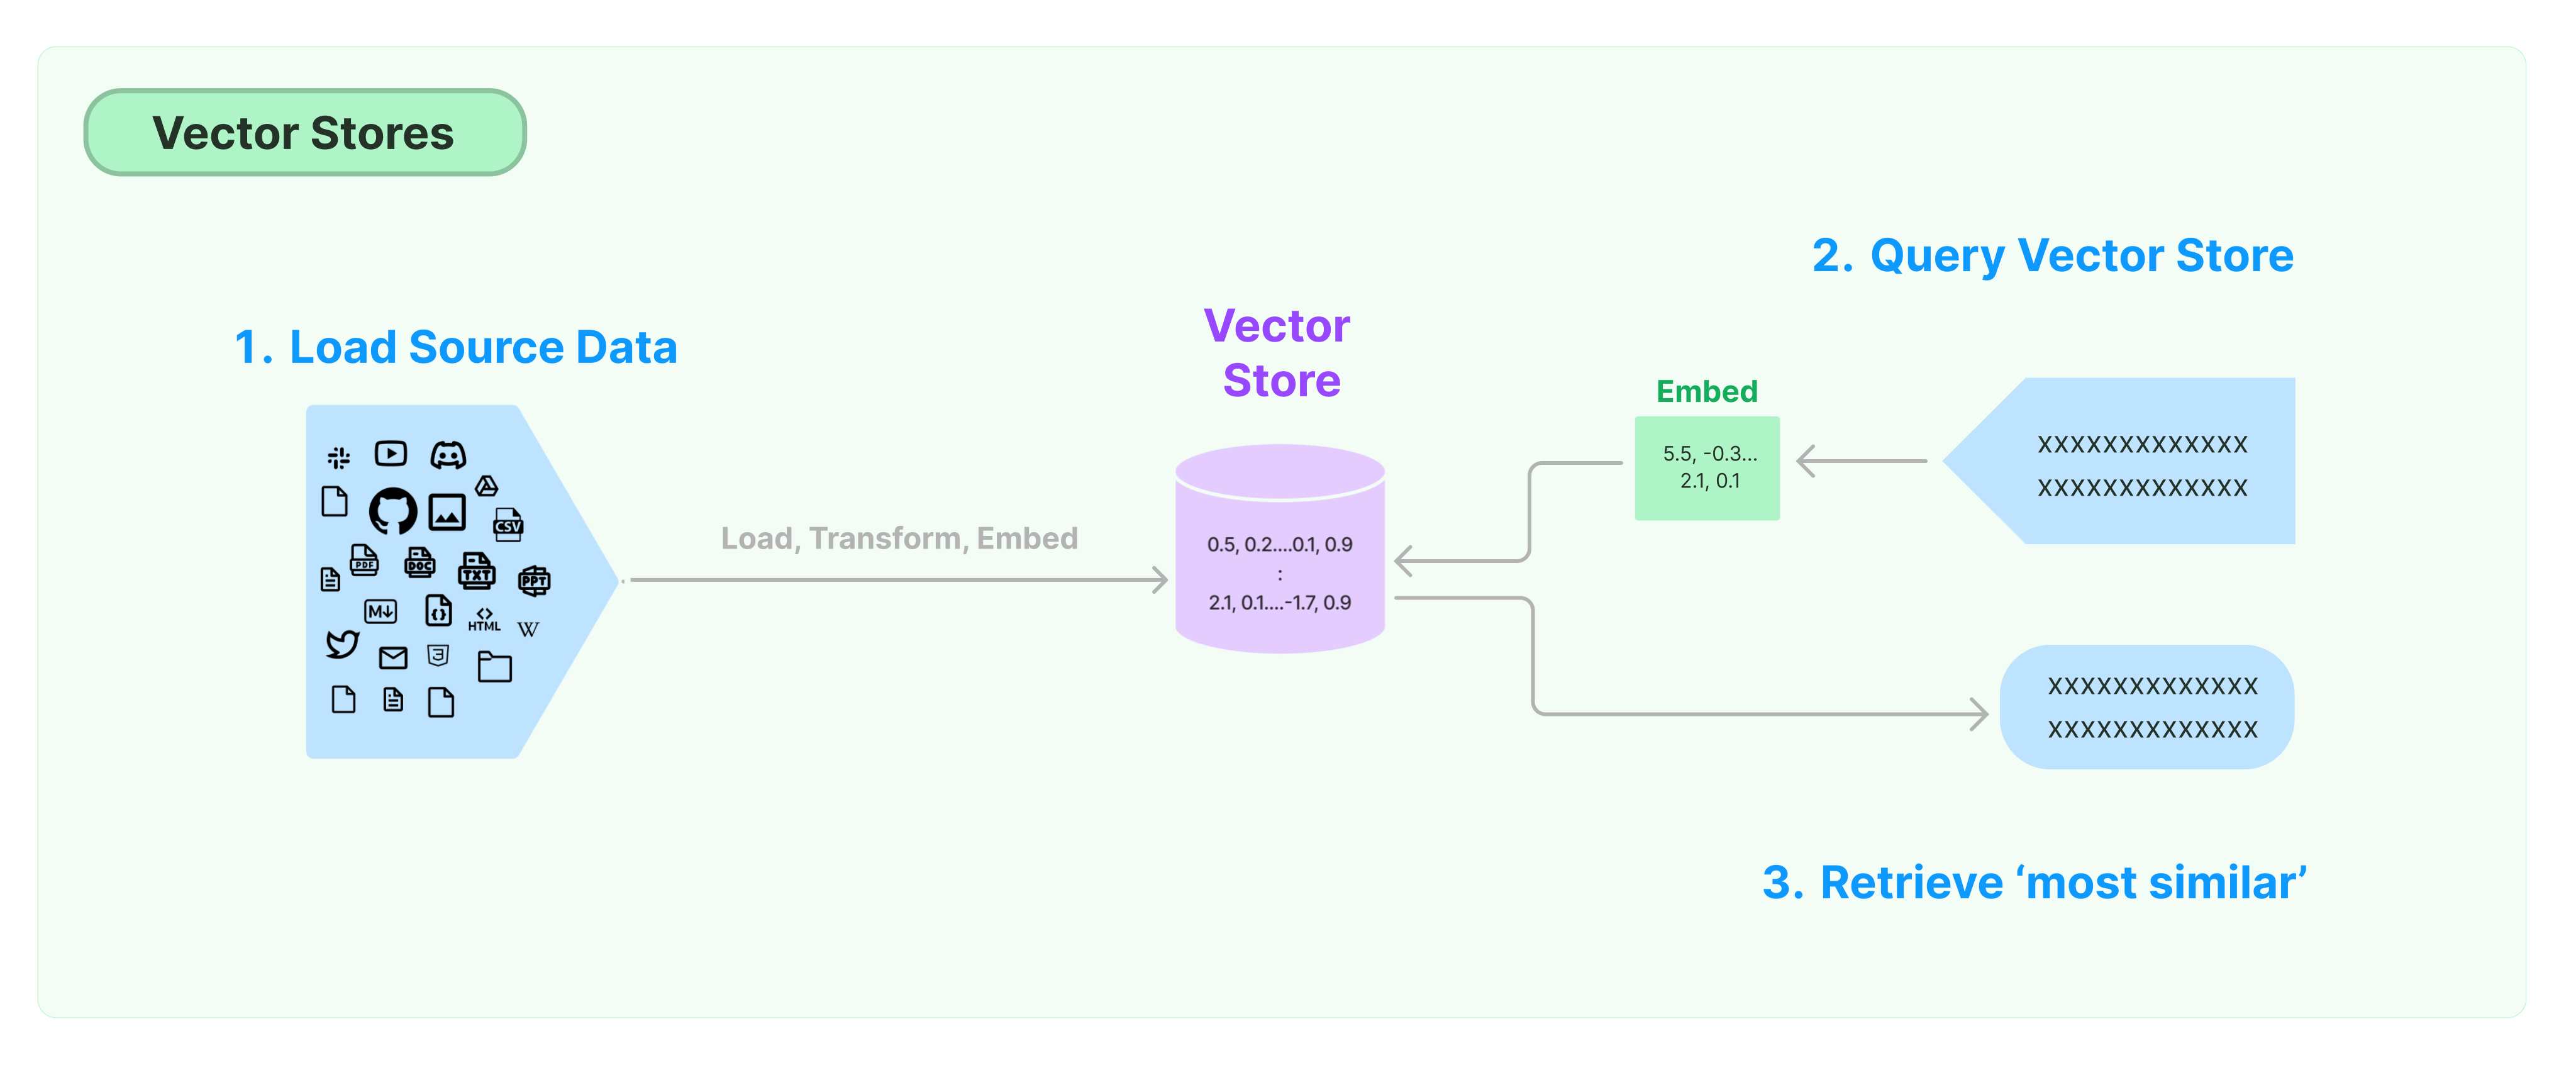

**View the dashboard using QDRANT_API_KEY: https://77fd7f57-43ed-4636-ba19-c70f60736415.us-east-1-0.aws.cloud.qdrant.io:6333/dashboard**

In [ ]:
# Qdrant Client
client = qdrant_client.QdrantClient(
    url = os.getenv("QDRANT_URL"),
    api_key = os.getenv("QDRANT_API_KEY")
    )

In [ ]:
# Embeddings
embeddings = OpenAIEmbeddings()

In [ ]:
# Create Collection for demo
collection_name = "ecommerce-demo"

collections = client.get_collections()
print(collections)

collections=[CollectionDescription(name='ecommerce-demo-1'), CollectionDescription(name='ecommerce-demo'), CollectionDescription(name='ecommerce')]


In [ ]:
# Only create collection if it doesn't exist
if collection_name not in [c.name for c in collections.collections]:
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=1536,
            distance=models.Distance.COSINE,
        ),
    )
collections = client.get_collections()
print(collections)

collections=[CollectionDescription(name='ecommerce-demo-1'), CollectionDescription(name='ecommerce-demo'), CollectionDescription(name='ecommerce')]


In [ ]:
# Get collection info - before adding data
client.get_collection(collection_name=collection_name)

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=0, indexed_vectors_count=0, points_count=0, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), payload_schema={})

In [ ]:
# Create Vector Store
vectorstore = Qdrant(
        client=client,
        collection_name=collection_name,
        embeddings=embeddings
    )

In [ ]:
# Add documents & payloads "metadata" to vector database
# Calling this cell multiple times duplicates the data everytime

# added_payloads = vectorstore.add_texts(
#     texts=texts,
#     metadatas=payloads
#     )

In [ ]:
# Get collection info - after adding data
client.get_collection(collection_name=collection_name)

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=1024, indexed_vectors_count=0, points_count=1024, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), payload_schema={})

### Semantic Search

In [ ]:
query = "hoodie"
found_docs = vectorstore.similarity_search_with_score(query, k=4)

In [ ]:
found_docs

[(Document(page_content="Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt", metadata={'availability': 'InStock', 'brand': 'Carhartt', 'currency': 'USD', 'description': 'This heavyweight, water-repellent hooded sweatshirt has a zip front for fast layering. ORIGINAL FIT. 13 oz., 75% cotton/25% polyester blend with Rain Defender durable water repellent. Attached, jersey-lined three-piece hood with drawcord closure. Antique-finish brass front zipper. Two front hand-warmer pockets have a hidden security pocket inside. Stretchable, spandex-reinforced rib-knit cuffs and waistband. Locker loop facilitates hanging.', 'price': 64.99, 'title': "Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt", 'url': 'https://www.homedepot.com/p/Carhartt-Men-s-3X-Large-Carbon-Heather-Cotton-Polyester-Rain-Defender-Paxton-Heavyweight-Hooded-Zip-Front-Sweatshirt-100614-026/310090686'}),
  0.8357206

In [ ]:
for doc in found_docs:
  print("Item:", doc[0].page_content)
  print("URL:", doc[0].metadata['url'], "\n")

Item: Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt
URL: https://www.homedepot.com/p/Carhartt-Men-s-3X-Large-Carbon-Heather-Cotton-Polyester-Rain-Defender-Paxton-Heavyweight-Hooded-Zip-Front-Sweatshirt-100614-026/310090686 

Item: Men's Small Dark Navy Modacrylic/Lyocell/Aramid Fleece FR HW Zip Front Sweatshirt
URL: https://www.homedepot.com/p/Carhartt-Men-s-Small-Dark-Navy-Modacrylic-Lyocell-Aramid-Fleece-FR-HW-Zip-Front-Sweatshirt-102908-410/308546978 

Item: Vigilante Premium Hood Protector - Smoke
URL: https://www.homedepot.com/p/STAMPEDE-Vigilante-Premium-Hood-Protector-Smoke-2055-2/310196180 



### Filtering

https://qdrant.tech/documentation/concepts/filtering/

## 4. ConversationalRetrievalChain

This chain works in two stages:
1. It combines the chat history (either explicitly passed in or retrieved from the provided memory) and the question into a standalone question using a separate question generation chain.
2. Looks up relevant documents from the retriever, and finally passes those documents and the question to a question answering chain to return a response.

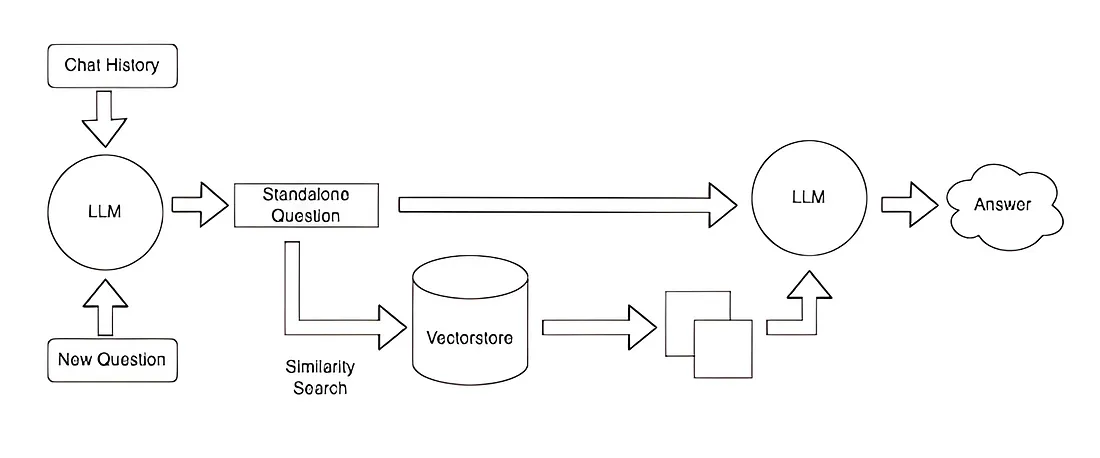

**https://python.langchain.com/docs/use_cases/question_answering/how_to/chat_vector_db**

In [ ]:
# For Chain
collection_name = "ecommerce"

vectorstore = Qdrant(
        client=client,
        collection_name=collection_name,
        embeddings=embeddings
    )

### 4.1 Output Parser

* Output parsers are classes that structure LLM responses. They extract precisely what is enumerated in a provided schema (e.g., specific attributes of a product).

* `PydanticOutputParser` class instructs the model to generate its output in a JSON format and then extract the information from the response. You will be able to treat the parser’s output as a list, meaning it will be possible to index through the results without worrying about formatting.

* This class uses the **Pydantic** library, which helps define and validate data structures in Python. It enables us to characterize the expected output with a name, type, and description. We need a variable that can store multiple suggestions in the thesaurus example. It can be easily done by defining a class that inherits from the **Pydantic**’s `BaseModel` class.

https://python.langchain.com/docs/use_cases/extraction

In [ ]:
class Product(BaseModel):
    """Product details schema."""
    url:str = Field(description="Full URL link to the product webpage on Homedepot.")
    title:str = Field(description="Title of the product.")
    description:str = Field(description="Description of the prodcut.")
    brand:str = Field(description="Manufacturing brand of the product.")
    price:float = Field(description="Unit selling price of the product.")


# Set up a parser
parser = PydanticOutputParser(pydantic_object=Product)

In [ ]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Product details schema.", "properties": {"url": {"description": "Full URL link to the product webpage on Homedepot.", "title": "Url", "type": "string"}, "title": {"description": "Title of the product.", "title": "Title", "type": "string"}, "description": {"description": "Description of the prodcut.", "title": "Description", "type": "string"}, "brand": {"description": "Manufacturing brand of the product.", "title": "Brand", "type": "string"}, "price": {"description": "Unit selling price of the product.", "title": "Price", "type

### Prompting

LLMs and Chat Models each have their advantages and disadvantages:

  - **LLMs** are powerful and flexible, capable of generating text for a wide range of tasks. However, their API is less structured compared to Chat Models.
  - **Chat Models** offer a more structured API and are better suited for conversational tasks. Also, they can remember previous exchanges with the user, making them more suitable for engaging in meaningful conversations. Additionally, they benefit from reinforcement learning from human feedback, which helps improve their responses. They still have some limitations in reasoning and may require careful handling to avoid hallucinations and generating inappropriate content.

Chat Completions vs. Completions:

  - The chat completions format can be made similar to the completions format by constructing a request using a single user message. For example, one can translate from English to French with the following completions prompt:
    - `Translate the following English text to French: "{text}"`
  - And an equivalent chat prompt would be:
    - `[{"role": "user", "content": 'Translate the following English text to French: "{text}"'}]`

#### Question Generation Prompt
By default, ConversationalRetrievalQA uses `CONDENSE_QUESTION_PROMPT` to condense a question.

In [ ]:
question_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:
"""

CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(question_template)

In [ ]:
# Chat LLM for question generation & Q&A
model_name = "gpt-3.5-turbo"
temperature = 0
llm_chat = ChatOpenAI(model=model_name, temperature=temperature)

In [ ]:
# Chain for question generation
question_generator = LLMChain(llm=llm_chat, prompt=CONDENSE_QUESTION_PROMPT)

#### Q&A Prompt through Role Prompting
Role prompting involves asking the LLM to assume a specific role or identity before performing a given task, such as acting as a **Retail Assistant**. This can help guide the model's response by providing a context or perspective for the task.

##### ChatPromptTemplate
In LangChain, three main types of messages are used when interacting with chat models: `SystemMessage`, `HumanMessage`, and `AIMessage`.

- **SystemMessage**: These messages provide initial instructions, context, or data for the AI model. They set the objectives the AI should follow and can help in controlling the AI's behavior. System messages are not user inputs but rather guidelines for the AI to operate within.
- **HumanMessage**: These messages come from the user and represent their input to the AI model. The AI model is expected to respond to these messages. In LangChain, you can customize the human prefix (e.g., "User") in the conversation summary to change how the human input is represented.
- **AIMessage**: These messages are sent from the AI's perspective as it interacts with the human user. They represent the AI's responses to human input. Like HumanMessage, you can also customize the AI prefix (e.g., "AI Assistant" or "AI") in the conversation summary to change how the AI's responses are represented.

In [ ]:
# System Prompt
system_template = """
You are a friendly, conversational retail shopping assistant. Use the following context including product names,
descriptions, and keywords to show the shopper whats available, help find what they want, and answer any questions.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context:
{context}
"""

system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

In [ ]:
# Human Prompt
human_template="""{format_instructions}

Question: {question}"""

# human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

# Inject instructions into the prompt template.
human_message_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template=human_template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
        )
    )

NameError: ignored

In [ ]:
# Chat Prompt
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
chat_prompt

ChatPromptTemplate(input_variables=['context', 'question'], output_parser=None, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], output_parser=None, partial_variables={}, template="\nYou are a friendly, conversational retail shopping assistant. Use the following context including product names,\ndescriptions, and keywords to show the shopper whats available, help find what they want, and answer any questions.\nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nContext:\n{context}\n", template_format='f-string', validate_template=True), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], output_parser=None, partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list o

In [ ]:
# Chain for Q&A
answer_chain = load_qa_chain(llm_chat,
                             chain_type="stuff",
                             prompt=chat_prompt)

In [ ]:
# Memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [ ]:
# Chain
qa = ConversationalRetrievalChain(
    retriever = vectorstore.as_retriever(),
    question_generator = question_generator,
    combine_docs_chain = answer_chain,
    memory=memory
)

In [ ]:
query = "I'm looking for a Hoodie"
result = qa({"question": query})

print(result['answer'])

Sure! We have a couple of hoodies available. Can you please provide me with more details about the hoodie you are looking for?


In [ ]:
query = "I want a middle size black hoodie"
result = qa({"question": query})

print(result['answer'])

{
  "url": "https://example.com/mens-hoodie",
  "title": "Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt",
  "description": "Stay warm and dry with this men's hoodie. Made with a cotton/polyester blend and featuring Rain Defender technology, this hoodie is perfect for outdoor activities. The heavyweight construction provides extra warmth, while the zip-front design allows for easy on and off. The carbon heather color adds a stylish touch to any outfit.",
  "brand": "Carhartt",
  "price": 59.99
}


In [ ]:
result

{'question': 'How about pants that can match this hoodie?',
 'chat_history': [HumanMessage(content="I'm looking for a Hoodie", additional_kwargs={}, example=False),
  AIMessage(content='Sure! We have a couple of hoodies available. Can you please provide me with more details about the hoodie you are looking for?', additional_kwargs={}, example=False),
  HumanMessage(content='I want a middle size black hoodie', additional_kwargs={}, example=False),
  AIMessage(content='{\n  "url": "https://example.com/mens-hoodie",\n  "title": "Men\'s 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt",\n  "description": "Stay warm and dry with this men\'s hoodie. Made with a cotton/polyester blend and featuring Rain Defender technology, this hoodie is perfect for outdoor activities. The heavyweight construction provides extra warmth, while the zip-front design allows for easy on and off. The carbon heather color adds a stylish touch to any outfit.",\n  

In [ ]:
df[df["title"] == json.loads(result['answer'])["title"]]

In [ ]:
query = "How about pants that can match this hoodie?"
result = qa({"question": query})

print(result['answer'])

{
  "url": "https://example.com/pants",
  "title": "Men's 38 in. x 36 in. Gravel Cotton/Spandex Medium Rugged Flex Rigby 5-Pocket Pant",
  "description": "These pants are made with a blend of cotton and spandex for comfort and flexibility. They have a medium fit and feature a rugged flex design. The gravel color adds a stylish touch.",
  "brand": "Brand XYZ",
  "price": 49.99
}


In [ ]:
df[df["title"] == json.loads(result['answer'])["title"]]

,url,title,images,description,product_id,sku,gtin13,brand,price,currency,availability,uniq_id,scraped_at
index,,,,,,,,,,,,,
431,https://www.homedepot.com/p/Carhartt-Men-s-38-...,Men's 38 in. x 36 in. Gravel Cotton/Spandex Me...,https://images.thdstatic.com/productImages/a0a...,Built with Rugged Flex stretch technology for ...,309887971,1.004416e+09,8.891924e+11,Carhartt,44.99,USD,InStock,73e29902-d2eb-5f04-9b31-5c88290f8f83,2021-12-14 00:57:26.499074


In [ ]:
query = "Is there any white shoes that can match the outfit?"
result = qa({"question": query})

print(result['answer'])

{
  "url": "https://www.homedepot.com/p/Mix-and-Match-White-3-Piece-Folding-Steel-Slat-Bistro-Set/312123456",
  "title": "Mix and Match White 3-Piece Folding Steel Slat Bistro Set",
  "description": "Create a cozy outdoor dining space with this Mix and Match White 3-Piece Folding Steel Slat Bistro Set. The set includes two folding chairs and a folding table, all made with a durable steel frame and a white slat design. The chairs feature a comfortable seat and backrest, while the table provides a convenient surface for dining or relaxing. Perfect for small patios, balconies, or any outdoor space.",
  "brand": "Mix and Match",
  "price": 149.99
}


In [ ]:
df[df["title"] == json.loads(result['answer'])["title"]]

,url,title,images,description,product_id,sku,gtin13,brand,price,currency,availability,uniq_id,scraped_at
index,,,,,,,,,,,,,
739,https://www.homedepot.com/p/StyleWell-Mix-and-...,Mix and Match White 3-Piece Folding Steel Slat...,https://images.thdstatic.com/productImages/532...,Set up a cozy spot with this StyleWell Mix and...,317368760,1.006468e+09,8.486811e+11,StyleWell,109.99,USD,InStock,afa625c8-a8b0-5098-9379-07e16fdf3167,2021-12-14 00:58:32.653614


## LangSmith - Debug, test and monitor your LLM application

We can use LangSmith to debug:

- An unexpected end result
- Why an agent is looping, so we can look into the sub-calls & reasoning steps
- Why a chain was slower than expected
- How many tokens an agent used


With LangSmith, we can:
1. See All the Runs in a project
2. See Run Details
3. Stepwise Visualization and Debugging
4. Optimize Token Usage and Latency
5. Utilize Tags
6. Gather User Feedback for Improvement
7. Easily Share and Rate Your Runs

https://docs.smith.langchain.com/overview